**Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,EarlyStopping,ModelCheckpoint

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

**Preprocessing and splitting data**

In [2]:
conv_images,labels=[],[]
def grayscale_resize(data_directory):
    categories=os.listdir(data_directory)
    
    for category in categories:
        
        images_folder=os.path.join(data_directory,category)
        given_images=os.listdir(images_folder)              
        
        for image_name in given_images:
            image_path=os.path.join(images_folder,image_name)
            image=cv2.imread(image_path)      
            gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            resized=cv2.resize(gray,(64,64))
            conv_images.append(resized)

            if category=='without_mask':
                labels.append(0)               
            elif category=='with_mask':
                labels.append(1)      
        
    return np.array(conv_images)/255,np.array(labels)   

In [3]:
data,labels=grayscale_resize('./images')

In [4]:
data=np.reshape(data,(data.shape[0],64,64,1))
labels=np_utils.to_categorical(labels)

In [5]:
X_train,X_test,Y_train,Y_test=train_test_split(data,labels,test_size=0.25)

**Viewing augmented images**

In [6]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        horizontal_flip=True,
        zoom_range=0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1)

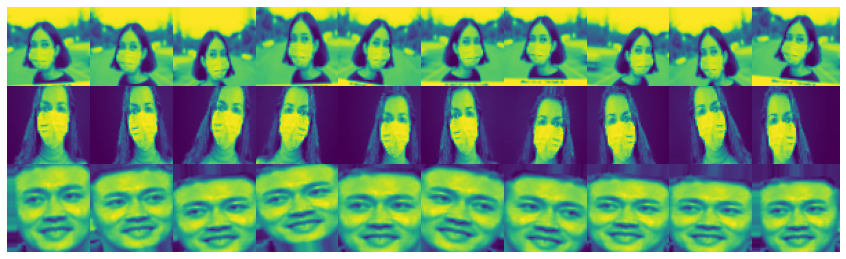

In [7]:
X_train3 = X_train[9,].reshape((1,64,64,1))
Y_train3 = Y_train[9,].reshape((1,2))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((64,64,1)))
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,64,64,1))
    if i==19: X_train3 = X_train[18,].reshape((1,64,64,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

**Plots for displaying loss and accuracy of model**

In [8]:
def accuracy_plot(model):
    plt.figure(figsize=(15,5))
    plt.plot(model.history['val_accuracy'],'r',label='validation accuracy')
    plt.plot(model.history['accuracy'],'b',label='train accuracy')   
    plt.ylabel('accuracy')
    plt.xlabel('epoch')  
    plt.legend(loc="lower left")    
    axes = plt.gca()
    axes.set_ylim([0.90,1])
    plt.show()

In [9]:
def loss_plot(model):
    plt.figure(figsize=(15,5))
    plt.plot(model.history['val_loss'],'r',label='validation loss')
    plt.plot(model.history['loss'],'b',label='train loss')   
    plt.ylabel('loss')
    plt.xlabel('epoch')  
    plt.legend(loc="lower left")
    plt.show()

# CNN architecture

**Initializing callback parameter**

In [22]:
callbacks1 = [ 
    LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x), 
    ModelCheckpoint('./best-cnn', save_best_only=True) # saving the best model
]

In [23]:
callbacks2 = [ 
    LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x), 
    ModelCheckpoint('./best-cnn-aug', save_best_only=True) # saving the best model
]

CNN architecture: 2 3x3 kernels paired with maxpool and dropout to extract features which is then flattened and passed to dense layer to predict outcome(mask/no mask)

In [24]:
model=Sequential()
model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(64,64,1)))
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

**Without augmentation**

In [25]:
history= model.fit(X_train,Y_train, batch_size=64, epochs = 25,  
        validation_data = (X_test,Y_test), callbacks=callbacks1)
print("Maximum train accuracy={0:.3f}, Maximum validation accuracy={1:.3f}".format(
       max(history.history['accuracy']),max(history.history['val_accuracy']) ))

Epoch 1/25
46/46 [==============================] - 18s 388ms/step - loss: 0.6439 - accuracy: 0.6137 - val_loss: 0.6305 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 2/25
46/46 [==============================] - 17s 362ms/step - loss: 0.4385 - accuracy: 0.8024 - val_loss: 0.3907 - val_accuracy: 0.8233 - lr: 9.5000e-04
Epoch 3/25
46/46 [==============================] - 19s 413ms/step - loss: 0.2795 - accuracy: 0.8894 - val_loss: 0.2330 - val_accuracy: 0.9054 - lr: 9.0250e-04
Epoch 4/25
46/46 [==============================] - 18s 401ms/step - loss: 0.1978 - accuracy: 0.9227 - val_loss: 0.2004 - val_accuracy: 0.9220 - lr: 8.5737e-04
Epoch 5/25
46/46 [==============================] - 16s 350ms/step - loss: 0.1423 - accuracy: 0.9487 - val_loss: 0.2286 - val_accuracy: 0.9033 - lr: 8.1451e-04
Epoch 6/25
46/46 [==============================] - 17s 365ms/step - loss: 0.1250 - accuracy: 0.9463 - val_loss: 0.1835 - val_accuracy: 0.9418 - lr: 7.7378e-04
Epoch 7/25
46/46 [==========================

In [26]:
model.save('cnn-model.hdf5') #saving model

**Plotting accuracy and loss**

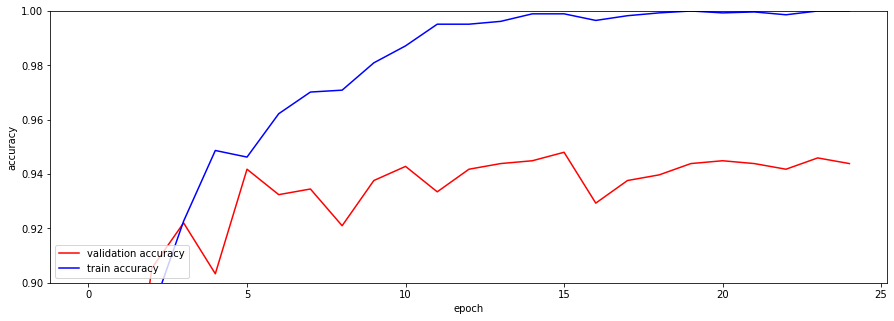

In [27]:
accuracy_plot(history)

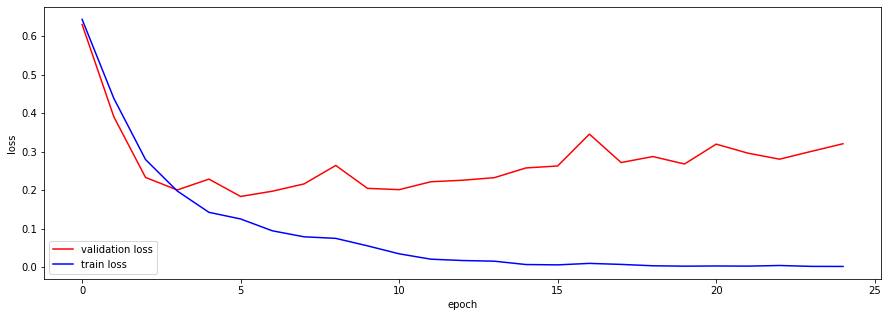

In [28]:
loss_plot(history)

**With augmentation**

In [30]:
history= model.fit(datagen.flow(X_train,Y_train, batch_size=64), epochs = 20,  
        validation_data = (X_test,Y_test), callbacks=callbacks2)
print("Maximum train accuracy={0:.3f}, Maximum validation accuracy={1:.3f}".format(
       max(history.history['accuracy']),max(history.history['val_accuracy']) ))

Epoch 1/20
46/46 [==============================] - 19s 412ms/step - loss: 0.2291 - accuracy: 0.9112 - val_loss: 0.1360 - val_accuracy: 0.9428 - lr: 0.0010
Epoch 2/20
46/46 [==============================] - 16s 348ms/step - loss: 0.2018 - accuracy: 0.9196 - val_loss: 0.1452 - val_accuracy: 0.9366 - lr: 9.5000e-04
Epoch 3/20
46/46 [==============================] - 17s 369ms/step - loss: 0.2050 - accuracy: 0.9161 - val_loss: 0.1172 - val_accuracy: 0.9553 - lr: 9.0250e-04
Epoch 4/20
46/46 [==============================] - 17s 368ms/step - loss: 0.1872 - accuracy: 0.9237 - val_loss: 0.1116 - val_accuracy: 0.9543 - lr: 8.5737e-04
Epoch 5/20
46/46 [==============================] - 16s 358ms/step - loss: 0.1652 - accuracy: 0.9345 - val_loss: 0.1141 - val_accuracy: 0.9532 - lr: 8.1451e-04
Epoch 6/20
46/46 [==============================] - 17s 366ms/step - loss: 0.1547 - accuracy: 0.9365 - val_loss: 0.0869 - val_accuracy: 0.9584 - lr: 7.7378e-04
Epoch 7/20
46/46 [==========================

In [31]:
model.save('./cnn-model-aug.hdf5')

**Plotting accuracy and loss**

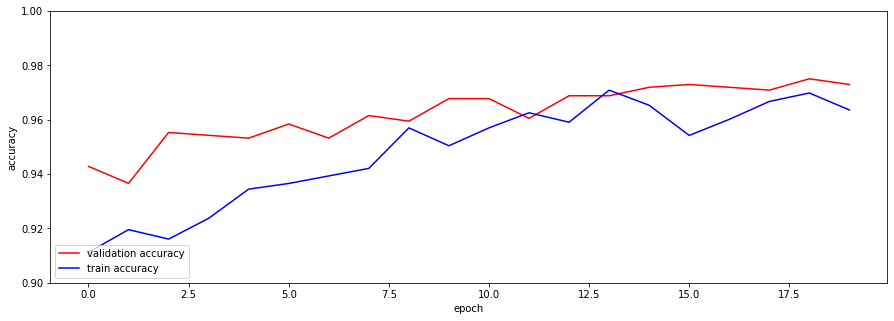

In [32]:
accuracy_plot(history)

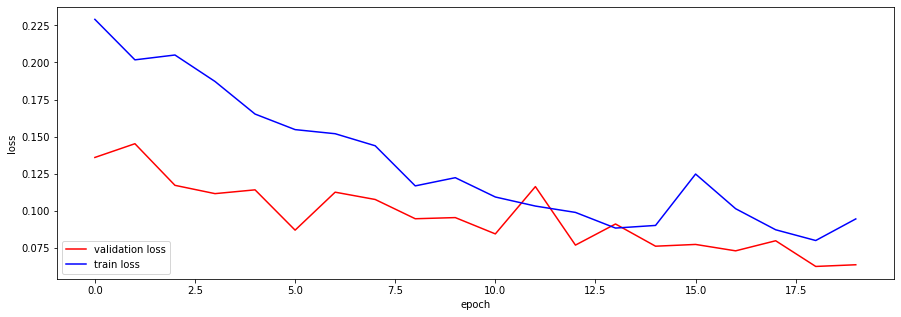

In [33]:
loss_plot(history)